# Coagulation Patterns: PMF Particle Distribution

This notebook explores the coagulation process using a Probability Mass Function (PMF) to define the initial particle size distribution. A PMF provides a representation of discrete particle sizes bins and their associated counts.

The PMF-based distribution allows us to model how the number of particles in each size category changes over time due to coagulation, providing insights into the size distribution's shift toward larger particles.

**PMF Particle Distribution:**
We initialize the particle size distribution using a PMF, where each particle bin has a concentration count. This discrete distribution captures the initial population of particles, categorized by size. The PMF provides flexibility in representing systems where specific particle sizes are dominant or where particles are grouped into size bins.

**Coagulation Process:**
The coagulation process is modeled using a discrete bin approach. We define the coagulation process using a flexible `Coagulation` class, which allows us to choose different coagulation strategies. In this notebook, we employ the `DiscreteSimple` strategy, which tracks each particle's properties as it undergoes coagulation.

**Imports:**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# particula imports
from particula.next import particles
from particula.next.aerosol import Aerosol

from particula.next.gas.species_builders import PresetGasSpeciesBuilder
from particula.next.gas.atmosphere_builders import AtmosphereBuilder

from particula.next.dynamics import particle_process
from particula.next.dynamics import coagulation

## Aerosol Setup

This section sets up the aerosol system, defining both the atmospheric conditions and the properties of the particles within it. We use the Builder pattern to construct the atmosphere and the particle mass distribution, ensuring that all parameters are defined explicitly and can be validated during the setup process.

**Atmospheric Setup**

The atmosphere is created using the `AtmosphereBuilder`. This class allows us to define key environmental parameters such as the gas species, temperature, and pressure.

- **Gas Species:** We add a preset gas species using the `PresetGasSpeciesBuilder`, which represents a non-condensing gas in the atmosphere.
- **Temperature:** The temperature is set to 25°C, representing typical atmospheric conditions.
- **Pressure:** Atmospheric pressure is set to 1 atm, simulating standard sea-level pressure.

The `build()` method finalizes the atmosphere object, which will be used in the aerosol simulation.

**Resolved Particle Mass Representation**

Next, we define the particle mass distribution using the `PresetParticleRadiusBuilder`. This builder allows for setting up a detailed particle distribution based on physical properties such as particle size (mode), geometric standard deviation (GSD), and number concentration. 

- **Mode:** The particle size modes are set to 100 nm and 800 nm, defining two distinct groups of particles within the aerosol.
- **Geometric Standard Deviation (GSD):** GSD values of 1.2 and 1.5 represent the spread of particle sizes within each mode, with the larger GSD indicating a broader distribution of particle sizes.
- **Number Concentration:** The number concentration for the two modes is defined as 1e5 and 2e5 particles per cm³, respectively.
- **Distribution Type:** We specify that the distribution follows a Probability Mass Function (PMF), which allows for a discrete representation of particle sizes.
- **Radius Bins:** The radius bins are defined using `np.logspace` to create a logarithmic spacing between particle radii ranging from 10 nm to 100 µm. This ensures that the distribution captures a wide range of particle sizes.

Once all parameters are set, the `build()` method finalizes the particle mass representation.

**Aerosol Object Creation**

Finally, the aerosol system is created by combining the atmospheric conditions and the resolved particle masses. The resulting `aerosol` object contains both the gas phase and particle distribution, ready for use in the coagulation simulation.

In [2]:
# Preset gas species that does not condense in the atmosphere
# AtmosphereBuilder constructs the atmosphere with predefined species
atmosphere = (
    AtmosphereBuilder()
    .add_species(PresetGasSpeciesBuilder().build())  # Add a preset gas species
    .set_temperature(25, temperature_units="degC")  # Set temperature to 25°C
    .set_pressure(1, pressure_units="atm")  # Set pressure to 1 atmosphere
    .build()  # Finalize the atmosphere object
)


# Build a resolved mass representation for each particle
# This defines how particle mass, activity, and surface are represented
radius_bins = np.logspace(-8, -5, 250)  # Define the radius bins for the resolved mass representation
resolved_masses = (
    particles.PresetParticleRadiusBuilder()
    .set_mode(np.array([100, 800]), mode_units="nm")  # Set the mode radius
    .set_geometric_standard_deviation(np.array([1.2, 1.5]))  # Set the geometric standard deviation
    .set_number_concentration(np.array([1e5, 2e5]), number_concentration_units="cm^-3")  # Set the number concentration
    .set_distribution_type('pmf')  # Set the distribution type to PMF
    .set_radius_bins(radius_bins, radius_bins_units="m")  # Set the radius bins
    .build()  # Finalize the resolved mass representation
)

# Create an aerosol object with the defined atmosphere and resolved particles
aerosol = Aerosol(atmosphere=atmosphere, particles=resolved_masses)

# Print the properties
print(aerosol)

Gas mixture at 298.15 K and 101325.0 Pa consisting of ['Preset100']
[0]: Particle Representation:
	Strategy: RadiiBasedMovingBin
	Activity: ActivityIdealMass
	Surface: SurfaceStrategyVolume
	Mass Concentration: 8.993e-04 [kg/m^3]
	Number Concentration: 3.000e+11 [#/m^3]


## Simulation

In this section, we define the coagulation process and run it over multiple time steps. Coagulation is the process by which particles in an aerosol collide and merge, resulting in fewer, larger particles over time. The `Coagulation` class is used to simulate this behavior in a stepwise manner, updating the particle size distribution as the simulation progresses.

**Defining the Coagulation Strategy and Process**

We start by selecting a coagulation strategy using `DiscreteSimple()`, which defines how particles will interact and merge during the coagulation process. In this case, the `DiscreteSimple` strategy simplifies the coagulation by treating particle collisions discretely, allowing for straightforward tracking of particle size and number changes.

- **Coagulation Strategy:** The strategy dictates how particle interactions are handled. Here, `DiscreteSimple` offers a simplified, yet effective, approach for discrete particle interactions.
- **Coagulation Process:** The `Coagulation` class orchestrates the entire process, taking the defined strategy and applying it to the aerosol particles over the specified time and sub-steps.

**Simulation Setup: Time and Sub-Steps**

The coagulation process runs over defined time steps and sub-steps:
- **Time Step:** Each time step simulates the evolution of the aerosol system over a specific interval. In this case, it is set to 1000, representing a coarse time resolution.
- **Sub-Steps:** The time step is further divided into 100 sub-steps, which ensures a finer resolution for particle interactions, capturing the nuances of the coagulation process more accurately.

**Running the Coagulation Process**

The coagulation process is executed for the first time step using the `execute()` method. This method updates the aerosol object, modifying the particle size distribution as particles collide and merge. After this step:
- **Radii After Step:** The particle radii are extracted again to observe the changes in size distribution due to coagulation.
- **Concentration After Step:** The concentration of particles in each size bin is updated and saved for comparison.


In [3]:
# Define the coagulation strategy and process
coagulation_strategy = coagulation.DiscreteSimple()
coagulation_process = particle_process.Coagulation(
    coagulation_strategy=coagulation_strategy
)

# Set up time and sub-steps for the coagulation process
time_step = 1000
sub_steps = 100

initial_radii = aerosol.particles[0].get_radius()
concentration_initial = np.copy(aerosol.particles[0].concentration)

# Perform coagulation process for step 1
aerosol = coagulation_process.execute(
    aerosol, time_step=time_step, sub_steps=sub_steps
)
radii_after_step_1 = aerosol.particles[0].get_radius()
concentration_step_1 = np.copy(aerosol.particles[0].concentration)

# Perform coagulation process for step 2
aerosol = coagulation_process.execute(
    aerosol, time_step=time_step, sub_steps=sub_steps
)
radii_after_step_2 = aerosol.particles[0].get_radius()
concentration_step_2 = np.copy(aerosol.particles[0].concentration)

## Graphing

In this section, we visualize how the particle size distribution evolves after each step of the coagulation process. The graph displays the number concentration of particles (in m⁻³) as a function of particle radius (in meters). We use three curves to represent the distribution at different stages of the simulation:

1. **Initial**: This curve represents the particle distribution before any coagulation occurs.
2. **Step 1**: This curve shows how the distribution has changed after one step of the coagulation process.
3. **Step 2**: This curve reflects the further evolution of the particle sizes after a second step of coagulation.


**Coagulation Effect**:

   - After the first step (orange line), the peaks shift downward, indicating a reduction in the number concentration of particles across both size ranges. This is due to smaller particles merging through coagulation, resulting in fewer particles overall.
   - After the second step (green line), the number concentration of particles continues to decrease, with the peaks further reducing in height.
   - The shift towards larger particles becomes more evident as the second peak moves slightly to the right. This is a typical result of coagulation, where larger particles grow as smaller particles merge into them.

**Distribution Changes**:

- **Decrease in Number Concentration**: Coagulation leads to a reduction in the number of smaller particles as they combine to form larger ones. This is reflected in the decrease in concentration after each step.
- **Shift Toward Larger Particles**: The coagulation process shifts the distribution toward larger particle sizes. While the first step results in some particles merging, the second step pushes this trend further, as seen in the slight shift of the second peak to larger radii.
- **Wider Distribution**: As the simulation progresses, the particle size distribution becomes broader, indicating increased variability in particle sizes. This suggests that coagulation is affecting particles across a range of sizes, not just those at the peaks.

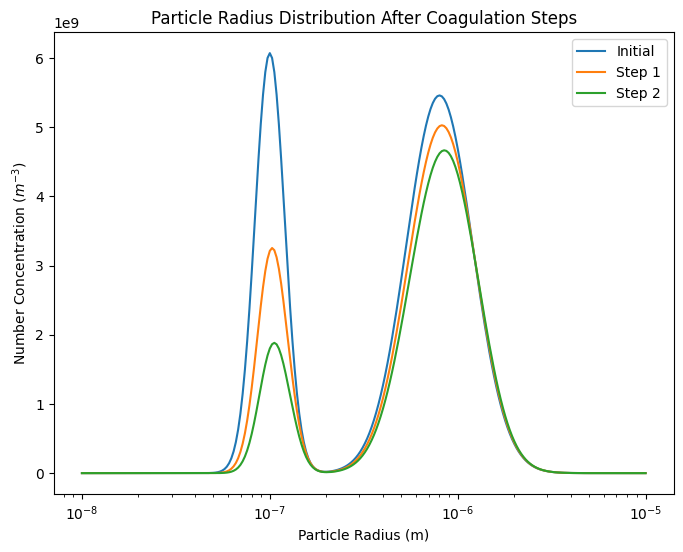

In [4]:
# Create figure for visualizing the histogram of particle radii
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the histogram of particle radii after step 1
ax.plot(initial_radii, concentration_initial, label="Initial")
ax.plot(radii_after_step_1, concentration_step_1, label="Step 1")
ax.plot(radii_after_step_2, concentration_step_2, label="Step 2")

# Set the labels and title of the plot
ax.set_xlabel("Particle Radius (m)")
ax.set_ylabel(r"Number Concentration ($m^{-3}$)")
ax.set_title("Particle Radius Distribution After Coagulation Steps")
ax.legend()
ax.set_xscale("log")
plt.show()

## Conclusion

This notebook demonstrates how a PMF-based particle distribution can be used to model the coagulation process in an aerosol system. By tracking the changes in particle size distribution over time, we can observe the shift towards larger particles due to coagulation. The discrete representation of particle sizes allows for detailed insights into how particles interact and merge, leading to changes in the aerosol composition.